In [75]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Dropout, Flatten, Dense
from keras.layers import Input, concatenate
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.optimizers import Adam
from keras.models import model_from_json
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm
from glob import glob
import cv2

Using TensorFlow backend.


In [2]:
'''
Make CycleGAN Model
'''
def cyclegan():
    img_shape = (128, 128, 3)
        
    ### 1. Build Discriminator
    D_A = discriminator()
    D_B = discriminator()
    
    D_A.trainable = True
    D_B.trainable = True 
    
    D_A.summary()
    
    D_A.compile(loss = 'mse', optimizer = Adam(0.0002, 0.5))
    D_B.compile(loss = 'mse', optimizer = Adam(0.0002, 0.5))
  
    ### 2. Build Generator pipeline
    G_A = generator() #oriental->photo
    G_B = generator() #photo->oriental
    
    D_A.trainable = False ## G를 학습하는 동안은 disciminator를 freeze
    D_B.trainable = False 
    
    real_A = Input(shape=img_shape)
    fake_B = G_A(real_A)
    f_label_B = D_B(fake_B) #discriminator의 fake 이미지 분류 예측값
    cycle_A = G_B(fake_B) #fake 이미지를 원래 형태로 복원시킨 이미지
    id_A = G_B(real_A)
    
    real_B = Input(shape=img_shape)
    fake_A = G_B(real_B)
    f_label_A = D_A(fake_A)
    cycle_B = G_A(fake_A)
    id_B = G_A(real_B)

    gen_pipe = Model(inputs = [real_A, real_B], outputs = [f_label_A, f_label_B, cycle_A, cycle_B, id_A, id_B])
    gen_pipe.compile(loss = ['mse','mse','mae','mae','mae','mae'], loss_weights = [1, 1, 10, 10, 1, 1], optimizer = Adam(0.0002, 0.5))
    gen_pipe.summary()
    
    return D_A, D_B, G_A, G_B, gen_pipe


'''
Discriminator Structure
'''
def discriminator():
    #<BN과 IN의 차이>
    #batch normalization - channel단위로 정규화
    #instance normalization - channel 내 배치단위로 정규화. content 이미지 내 feature statistics를 normalize해 style variation(재질,무늬,색깔,조명 등 방해요소)을 제거

    inp = Input(shape = (128, 128, 3))

    conv1 = Conv2D(32, kernel_size = 4, strides=2, padding='same')(inp) #w/o instancenorm
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    conv2 = Conv2D(64, kernel_size = 4, strides=2, padding='same')(conv1)
    conv2 = LeakyReLU(alpha = 0.2)(InstanceNormalization()(conv2))
    
    conv3 = Conv2D(128, kernel_size = 4, strides=2, padding='same')(conv2)
    conv3 = LeakyReLU(alpha = 0.2)(InstanceNormalization()(conv3))

    outp = Conv2D(1, kernel_size = 4, padding='same')(conv3) #label 추출 -> examine by pieces

    d = Model(inp, outp)
#         print(d.summary())

    return d


'''
Generator Structure
'''
def generator():
    #U-Net형식으로 구성 - 잔차연결 사용
    inp = Input(shape = (128, 128, 3))
    
    #Downsampling
    def downsample(layer, filters, kernels):
        x = Conv2D(filters, kernel_size = kernels, strides = 2, padding='same')(layer)
        x = InstanceNormalization()(x)
        x = LeakyReLU(alpha = 0.2)(x)
        return x
    
    #Upsampling
    def upsample(layer, connect, filters, kernels): 
        x = Conv2D(filters, kernel_size = kernels, padding='same')(UpSampling2D(size=2)(layer))
        x = InstanceNormalization()(x)
        x = ReLU()(x)
        return concatenate([x,connect])

    conv1 = downsample(inp, 32, 4)
    conv2 = downsample(conv1, 64, 4)
    conv3 = downsample(conv2, 128, 4)
    conv4 = downsample(conv3, 32*8, 4)
    conv5 = upsample(conv4, conv3, 128, 4)
    conv6 = upsample(conv5, conv2, 64, 4)
    conv7 = upsample(conv6, conv1, 32, 4)
    outp = Conv2D(3, kernel_size = 4, padding='same', activation = 'tanh')(UpSampling2D(size=2)(conv7)) #return to rgb channel

    g = Model(inp, outp)
#         print(g.summary())

    return g


'''
Train Model
'''
def main(styles, photos, epoch, batch_size=1): #SGD
    end = int( min(styles.shape[0],photos.shape[0]) / batch_size)
    
    D_A, D_B, G_A, G_B, gen_pipe = cyclegan()

    real_label = np.ones((batch_size,16,16,1))
    fake_label = np.zeros((batch_size,16,16,1))
    losses_D_A=[]
    losses_D_B=[]
    losses_G=[]

    for j in range(epoch):
        for i in range(end):

            style = styles[np.random.randint(0, end, size = batch_size)]
            photo = photos[np.random.randint(0, end, size = batch_size)]
            
            #generator에서 fake_A, fake_B를 생성
            stop_fake = G_A.predict(style)
            ptos_fake = G_B.predict(photo)

            #discriminator train : fake는 0, real은 1값이 나오도록
            loss_D_A_r = D_A.train_on_batch(style, real_label)
            loss_D_A_f = D_A.train_on_batch(ptos_fake, fake_label)
            loss_D_A =(loss_D_A_r+loss_D_A_f)/2

            loss_D_B_r = D_B.train_on_batch(photo, real_label)
            loss_D_B_f = D_B.train_on_batch(stop_fake, fake_label)
            loss_D_B = (loss_D_B_r+loss_D_B_f)/2
            
            losses_D_A.append(loss_D_A)
            losses_D_B.append(loss_D_B)
            
            #generator train : pipeline 들어갔을 시 discriminator들이 fake 에 대하여 1을 출력하게끔
            loss_G = gen_pipe.train_on_batch([style, photo], [real_label,real_label,style,photo,style,photo])
            losses_G.append(loss_G)
            
            #print image & save
            if i%150 ==0:
                print("epoch : {}, iteration: {}, D Loss : {:.3f}, G Loss(photo->style) : {:.3f}".format(j, i, (loss_D_A+loss_D_B)/2, loss_G[0]))
                fig = plt.figure()
                ax = plt.subplot("131")
                ax.set_title("Original")
                ax.imshow((( photo.reshape(128,128,3) +1 )*127.5).astype(np.uint8)) #scale back

                ax = plt.subplot("132")
                ax.set_title("Transferred")
                ax.imshow((( ptos_fake.reshape(128,128,3) + 1 )*127.5).astype(np.uint8))
                
                ax = plt.subplot("133")
                ax.set_title("Cycle")
                ax.imshow((( G_A.predict(ptos_fake).reshape(128,128,3) + 1 )*127.5).astype(np.uint8))
                
                fig.savefig("trainprocess/epoch{}batch{}".format(j,i))
                plt.close()
                
    return G_B, losses_D_A, losses_D_B, losses_G

In [3]:
def getimage(dataset_name, t, batch=1):
    A = glob('./datasets/oriental2photo/trainA/*')
    B = glob('./datasets/oriental2photo/trainB/*')
    
    if t=='style':
        where = A
    else:
        where = B
        
    images = []
    for _ in tqdm(where):
        image = cv2.imread(_)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #bgr -> rgb
        image = cv2.resize(image, dsize=(128, 128))
        images.append(image)
    
    return np.array(images)/127.5-1 #scale to -1~1

In [4]:
styles = getimage(batch = 1, t = 'style')
photos = getimage(batch = 1, t = 'photo')

100%|██████████| 6287/6287 [00:11<00:00, 538.96it/s]


In [5]:
with tf.device('/device:GPU:1'):
    transfer_generator, losses_D_A, losses_D_B, losses_G = main(styles, photos, epoch=200, batch_size=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
instance_normalization_1 (In (None, 32, 32, 64)        2         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1312

/home/jihye.kwon.conda/anaconda3/envs/jhenv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/jihye.kwon.conda/anaconda3/envs/jhenv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/jihye.kwon.conda/anaconda3/envs/jhenv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch : 0, iteration: 0, D Loss : 1.856, G Loss(photo->style) : 11.932


/home/jihye.kwon.conda/anaconda3/envs/jhenv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch : 0, iteration: 150, D Loss : 0.155, G Loss(photo->style) : 7.561
epoch : 0, iteration: 300, D Loss : 0.270, G Loss(photo->style) : 6.821
epoch : 0, iteration: 450, D Loss : 0.283, G Loss(photo->style) : 5.355
epoch : 1, iteration: 0, D Loss : 0.130, G Loss(photo->style) : 4.904
epoch : 1, iteration: 150, D Loss : 0.106, G Loss(photo->style) : 7.873
epoch : 1, iteration: 300, D Loss : 0.354, G Loss(photo->style) : 5.427
epoch : 1, iteration: 450, D Loss : 0.128, G Loss(photo->style) : 6.652
epoch : 2, iteration: 0, D Loss : 0.103, G Loss(photo->style) : 4.897
epoch : 2, iteration: 150, D Loss : 0.294, G Loss(photo->style) : 4.591
epoch : 2, iteration: 300, D Loss : 0.079, G Loss(photo->style) : 4.817
epoch : 2, iteration: 450, D Loss : 0.128, G Loss(photo->style) : 5.906
epoch : 3, iteration: 0, D Loss : 0.071, G Loss(photo->style) : 4.817
epoch : 3, iteration: 150, D Loss : 0.043, G Loss(photo->style) : 6.627
epoch : 3, iteration: 300, D Loss : 0.126, G Loss(photo->style) : 6.57

In [6]:
G_loss=[i[0] for i in np.array(losses_G)]

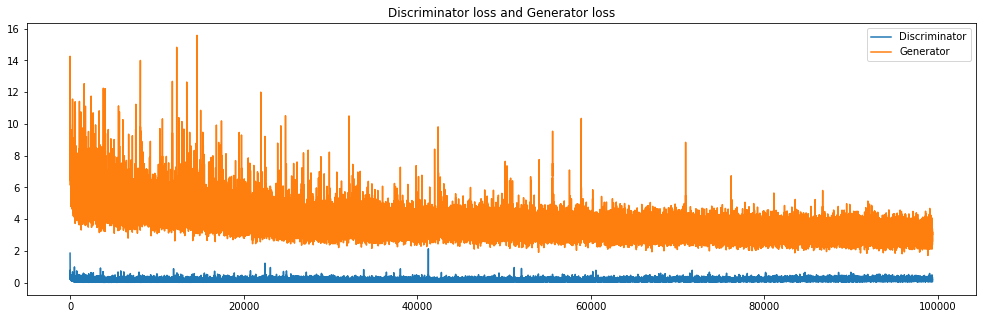

In [7]:
plt.figure(figsize=(17,5))
plt.plot(np.add(losses_D_A,losses_D_B)/2,label="Discriminator")
plt.plot(G_loss,label="Generator")
plt.legend()
plt.title('Discriminator loss and Generator loss')
plt.show()

In [8]:
G_json = transfer_generator.to_json()
with open("generator_git.json","w") as file:
    file.write(G_json)
transfer_generator.save_weights("generator_git.h5")

## Get Model Weights

In [9]:
file = open('generator_git.json','r')
g_model = file.read()
file.close()
generator = model_from_json(g_model,custom_objects={'InstanceNormalization':InstanceNormalization
})
generator.load_weights("generator_git.h5")

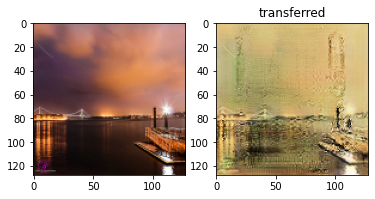

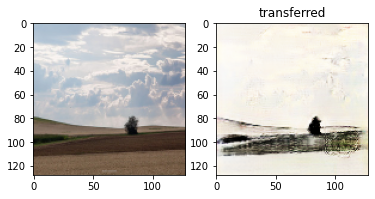

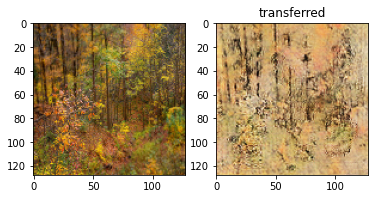

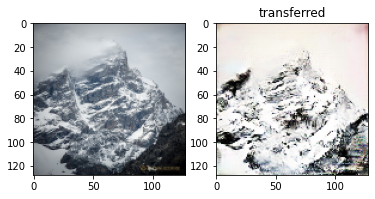

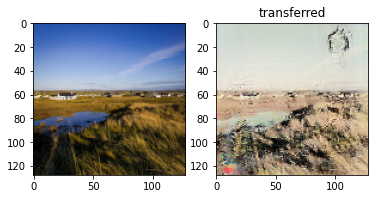

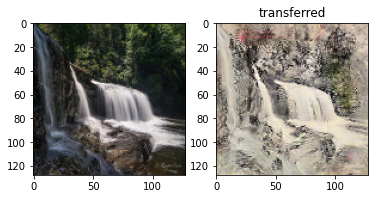

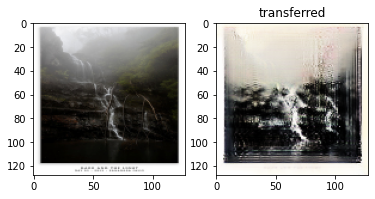

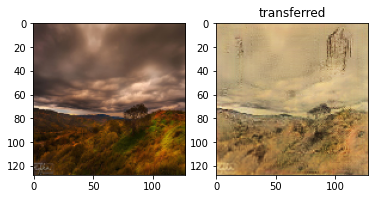

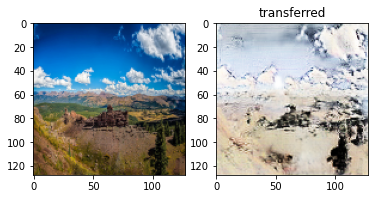

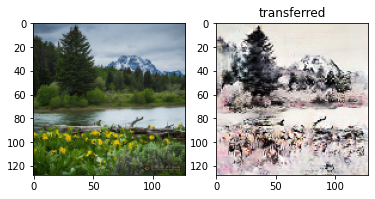

In [20]:
#check test data
test = glob('./datasets/oriental2photo/testB/*')
for _ in test[40:50]:
    image = cv2.imread(_)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #bgr->rgb
    image = cv2.resize(image, dsize=(128,128))
    image = image/127.5-1
    image = image.reshape(1,128,128,3)
    styletransferred = generator.predict(image)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(((image.reshape(128,128,3)+1)*127.5).astype(np.uint8))
    ax[1].imshow(((styletransferred.reshape(128,128,3)+1)*127.5).astype(np.uint8))
    plt.title('transferred')
    plt.show()